Having enough data for machine learning can help to overcome overfitting. Overfitting occurs when a model learns the noise and irrelevant details in the training data, leading to poor generalization when predicting with new data. This means that the model performs well on the training data but performs poorly on new data. It is an undesirable behavior that negatively impacts the model's ability to make predictions or classify data. To detect overfitting, data scientists can evaluate the model on both the training data and a holdout test data set and compare the performance.

## 14.1 Learning Curves

The _learning curve_ of a machine learning model shows how the performance of the model changes as the amount of training data increases. For a good model, we would expect to see the performance improve as more training data is added. However, at some point, the performance will start to plateau, indicating that adding more training data will not significantly improve the model's performance. When analyzing a learning curve, we look for this plateau to determine if we have enough training data for our model. Additionally, we can use the learning curve to diagnose whether our model is suffering from high bias or high variance. If the learning curve shows that the training and validation errors converge and are high, this indicates that our model has high bias and is underfitting the data. On the other hand, if the training error is low but the validation error is high and does not converge with the training error, this indicates that our model has high variance and is overfitting the data.

A learning curve, which shows how well a machine learning model is doing as it is trained on more and more data. A good learning curve shows that the model is getting better and better at making predictions as it sees more data. The model might do even better if it had even more data to learn from. Additionally, a good learning curve shows that the model is not memorizing the training data or failing to learn from it. 

In [1]:
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile
from hyperopt import fmin, tpe, hp, Trials

from EffectiveXGBoost import *

In [2]:
path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

raw = extract_dataset(path_url, file_name, dataset)

# Create raw X and raw y
kag_X, kag_y = prepX_y(raw, 'Q6')

# Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = (model_selection
                                                    .train_test_split(kag_X, 
                                                                      kag_y, 
                                                                      test_size=.3, 
                                                                      random_state=42, 
                                                                      stratify=kag_y)
                                                   )


# Transform X with pipeline
pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X_train = pline.fit_transform(kag_X_train)
X_test = pline.transform(kag_X_test)

# Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

# Default training
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)
xg.get_params()

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:62: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [3]:
params = {'learning_rate': 0.3,
'max_depth': 2,
'n_estimators': 200,
'n_jobs': -1,
'random_state': 42,
'reg_lambda': 0,
'subsample': 1}


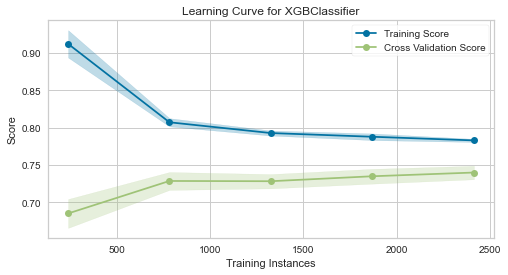

(0.6, 1.0)

In [4]:
import yellowbrick.model_selection as ms
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(xgb.XGBClassifier(**params),
X, y, ax=ax
)
ax.set_ylim(0.6, 1)

## 14.2 Learning Curves for Decision Trees

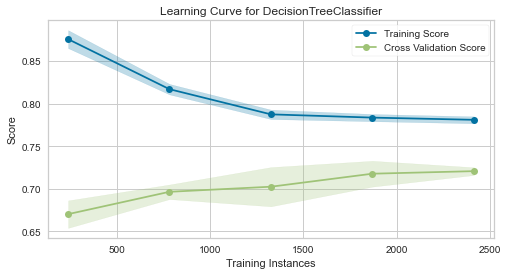

(0.6, 1.0)

In [5]:
# tuned tree
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(max_depth=7), 
                        X, y, ax=ax)
viz.ax.set_ylim(0.6, 1)

## 14.3 Underfit Learning Curves

We will be discussing the learning curve for an underfit model, which is a model that is too simple to learn from the data. In this case, the model being discussed is a decision stump model. The learning curve for an underfit model will show a low and constant cross-validation score as the amount of training data increases. This means that even as the model sees more and more data, its performance does not improve because it is too simple to learn from the data. The text also mentions that the performance on the training data would also be poor, with both the training and testing scores being similarly bad. If you look at the learning curve, you can see that the model cannot learn the underlying patterns in the data and needs to be more complex.

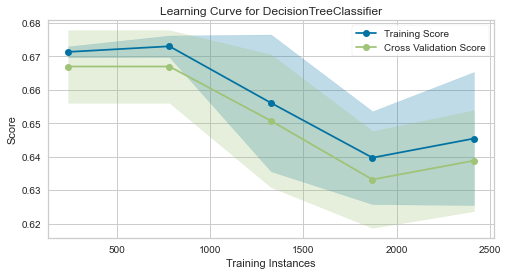

(0.6, 1.0)

In [6]:
# underfit
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(max_depth=1),
                        X, y, ax=ax)
ax.set_ylim(0.6, 1)

## 14.4 Overfit Learning Curves
 An overfit model is one that has been trained too well on the training data, to the point where it has learned the noise and details of the training data, but performs poorly on new data. The model has been allowed to grow unbounded by using the default parameters. The learning curve for an overfit model will show good performance on the training data but poor performance on the testing data. This means that the model has memorized the training data but cannot generalize its knowledge to new data. This learning curve is an excellent example of a model that is too complex.

One way to prevent overfitting in machine learning is to use cross-validation, which is a technique that helps to ensure that the model generalizes well to new data. Another way to prevent overfitting is to train with more data, which can help algorithms detect the signal better.

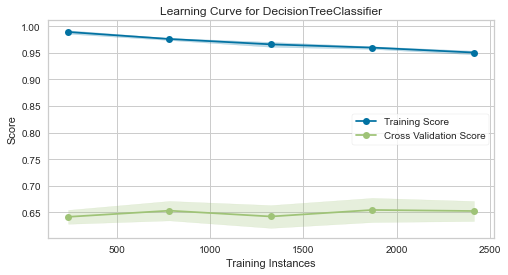

(0.6, 1.0)

In [8]:
# overfit
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(),
                        X, y, ax=ax)
ax.set_ylim(0.6, 1)

## Summary
1. The relationship between the performance of a machine learning model and the amount of data used to train it is generally positive. As the amount of data used to train the model increases, the performance of the model typically improves. This is because more data allows the model to better capture the underlying patterns and relationships in the data. However, there may be a point of diminishing returns where adding more data does not significantly improve performance.

2. Having enough data for machine learning can help overcome overfitting by allowing the model to better generalize to new data. Overfitting occurs when a model is too complex and fits the training data too closely, including noise and random fluctuations in the data. This can result in poor performance on new data. By having enough data, the model can better capture the underlying patterns and relationships in the data while ignoring noise and random fluctuations.

3. A learning curve is a plot that shows how the performance of a machine learning model changes as the amount of training data increases. It is used to evaluate the performance of a machine learning model by showing how well the model is able to learn from the data.

4. The purpose of plotting a learning curve for a machine learning model is to help diagnose problems with the model and determine if more data is needed to improve performance. A learning curve can show if a model is overfitting or underfitting, and can help determine if adding more data will improve performance.

5. Some characteristics of a good learning curve for a machine learning model include a steady increase in performance as more data is added, and a plateau where adding more data does not significantly improve performance. A good learning curve should also show that the model is not overfitting or underfitting.

6. The learning curve of a model can be used to determine if it is overfitting or underfitting by examining how well it performs on both training and validation data as more data is added. If the model performs well on training data but poorly on validation data, it may be overfitting. If it performs poorly on both training and validation data, it may be underfitting.
